In [1]:
import sys

# current root
base_dir = r'/Users/antoinevanbiesbroeck/Documents/GitHub/Nils/Computo_VA-RP'
sys.path.append(base_dir)
import os

py_dir = os.path.join(base_dir, "python_files")
if py_dir not in sys.path:
    sys.path.append(py_dir)
#print(sys.path)
from aux_optimizers import *
from stat_models_torch import *
from neural_nets import *
from variational_approx import *
from div_metrics_torch import *
from constraints import *

import scipy.special as spc
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import gridspec
import pickle
import torch
import numpy as np


path_plot = os.path.join(base_dir, "plots_data")

# On non constrained model

In [35]:
#1. recover the VARP
p = 50   
q = 2      
N = 50     
J = 500   
T = 50     
input_size = p  
output_size = q
low = 0.0001        
upp = 1 + low
mu_a, sigma2_a = 0, 1
#mu_a, sigma2_a = 8.7 * 10**-3, 1.03
Probit = torch_ProbitModel(use_log_normal=True, mu_a=mu_a, sigma2_a=sigma2_a, set_beta=None, alt_scaling=True)
n_samples_prior = 10**6
alpha = 0.5
name_file = 'Probit_results_unconstrained_torch_state'
file_path = os.path.join(path_plot, name_file)

seed_all(0)
sqrt2 = np.sqrt(2)
act_bet = lambda x: torch.log(1- 0.5*(1+torch.erf(x/sqrt2)) )
NN = NetProbitSeparate(input_size, m1=0, s1=0.1, b1=0, pre_act=[nn.Identity(), act_bet], act1=[torch.exp, torch.exp])
# NN = DifferentActivations(NN, [torch.exp, nn.Softplus()])
# NN = AffineTransformation(NN, low, upp)
NN.load_state_dict(torch.load(file_path, weights_only=True))
VA = VA_NeuralNet(neural_net=NN, model=Probit)

In [36]:
# 2. load a data file and compute posteriors

n_samples_post = 5000
T_mcmc = 2*10**5 + 1 
sigma2_0 = torch.tensor(1.)
eps_0 = torch.randn(p)

def aposteriori_VARP(numb_file) :
    file_path = os.path.join(base_dir, r'SUR_alpha_impact/run_AJ/model_noSUR_J_{}'.format(numb_file))

    file = pickle.load(open(file_path, 'rb'))
    data_A = file['A']
    data_Z = file['S']
    
    theta_logs = {}

    for N in np.arange(1,26)*10 :

        seed_all(0)
        Xstack = np.stack((data_Z[:N],data_A[:N]),axis=1)
        X = torch.tensor(Xstack)
        D = X.unsqueeze(1)
        Probit.data = D
        #eps_0 = 10 * torch.ones(p)
        eps_MH, batch_acc = VA.MH_posterior(eps_0, T_mcmc, sigma2_0, target_accept=0.4, adap=True, Cov=True, disable_tqdm=False)
        theta_MH = NN(eps_MH)
        with torch.no_grad():
            theta_MH = theta_MH.detach().numpy()
        theta_post_nocstr = theta_MH[-n_samples_post:,-n_samples_post:]

        theta_logs[N] = theta_post_nocstr

    pickle.dump({'logs':{'post': theta_logs}, 'A':data_A, 'S':data_Z }, open(os.path.join(base_dir, r'SUR_alpha_impact/run_AJ/model_noSUR_VARP_{}'.format(numb_file)), 'wb') )

files_numb = [3,30,31,32,33,34,35,36,37,38]

def all_aposterioriVARP() :
    for i in files_numb:
        aposteriori_VARP(i)

In [37]:
all_aposterioriVARP()

Metropolis-Hastings iterations:  51%|█████     | 101866/200000 [01:56<01:52, 874.31it/s]


KeyboardInterrupt: 

/Users/antoinevanbiesbroeck/opt/anaconda3/envs/new/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/antoinevanbiesbroeck/opt/anaconda3/envs/new/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Text(0, 0.5, '$P_f(a)$')

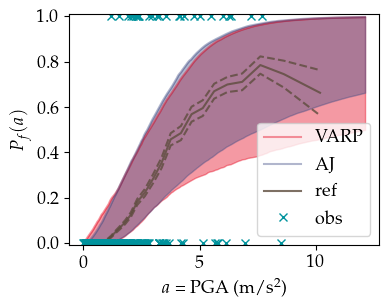

In [33]:
#3. output an example of estimate
from bayes_frag import config
from bayes_frag.data import Data
from bayes_frag.reference_curves import Reference_saved_MLE
from bayes_frag import plot_functions

data = Data('PGA', csv_path='Res_ASG_SA_PGA_RL_RNL_80000.csv', quantile_C=0.9, name_inte='rot_nlin', shuffle=True)
ref = Reference_saved_MLE(data, os.path.join(config.data_path, 'ref_MLE_ASG_80000_{}'.format('PGA')))
num_clust = 25
ref._compute_empirical_curves(num_clust) 
ref._compute_MC_data_tab()

numb_file= 31
N = 50

file_VARP = os.path.join(base_dir, r'SUR_alpha_impact/run_AJ/model_noSUR_VARP_{}'.format(numb_file))
file_J = os.path.join(base_dir, r'SUR_alpha_impact/run_AJ/model_noSUR_J_{}'.format(numb_file))


def compute_frags_cred(theta) :
    curves = 1/2 + 1/2*spc.erf( (np.log(data.a_tab)[None] - np.log(theta[:,None,0]))/theta[:,None,1] )
    q1 = np.quantile(curves, 1-0.05/2, axis=0)
    q2 = np.quantile(curves, 0.05/2, axis=0)
    return q1,q2

model_J = pickle.load(open(file_J, 'rb'))
model_VARP = pickle.load(open(file_VARP, 'rb'))

fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot()
q1,q2 = compute_frags_cred(model_VARP['logs']['post'][50])
ax.fill_between(data.a_tab, q1, q2, color='#E50019', alpha=0.4)
ax.plot(data.a_tab, q1, color='#E50019', alpha=0.4, label='VARP')


q1,q2 = compute_frags_cred(model_J['logs']['post'][50])
ax.fill_between(data.a_tab, q1, q2, color='#3E4A83', alpha=0.4)
ax.plot(data.a_tab, q1, color='#3E4A83', alpha=0.4, label='AJ')



ax.plot(ref.a_tab_MC, ref.curve_MC, color='#5E4C3D', alpha=0.8, label='ref')
ax.plot(ref.a_tab_MC, ref.curve_MC-ref.curve_MC_var, '--', color='#5E4C3D', alpha=0.8)
ax.plot(ref.a_tab_MC, ref.curve_MC+ref.curve_MC_var, '--', color='#5E4C3D', alpha=0.8)

ax.plot(model_J['A'].squeeze(), model_J['S'].squeeze(), 'x', color='#00939D', label='obs')

ax.legend()
ax.set_ylim(-0.01, 1.01)
ax.set_xlabel(r'$a$ = PGA (m/s$^2$)')
ax.set_ylabel(r'$P_f(a)$')



In [26]:
np.array(list(model_VARP['logs']['post'].values())).max()


230063570.0

# On contrained prior

In [2]:
#1. recover the VARP
kappa = 0.15
# K_val = np.mean((theta_sample_prior[:,1]**kappa)**(1/alpha))
# c_val = np.mean((theta_sample_prior[:,1]**kappa)**(1+1/alpha))
constr_val = 0.839594841003418
# alpha_constr = np.mean((theta_sample_prior[:,0]**-kappa + 1)**-1)
# print(f'Constraint value estimation : {K_val/c_val}')  # = 0.839594841003418 

# Parameters and classes
p = 50     # latent space dimension
q = 2      # parameter space dimension
N = 50    # number of data samples
J = 500    # nb samples for MC estimation in MI
T = 50     # nb samples MC marginal likelihood
alpha = 0.5
input_size = p  
output_size = q
low = 0.0001          # lower bound 
upp = 1 + low
n_samples_prior = 10**6

mu_a, sigma2_a = 0, 1
#mu_a, sigma2_a = 8.7 * 10**-3, 1.03
Probit = torch_ProbitModel(use_log_normal=True, mu_a=mu_a, sigma2_a=sigma2_a, set_beta=None, alt_scaling=True)

# Constraints
beta = torch.tensor([kappa])
b = torch.tensor([[1,constr_val]]) 
T_cstr = 100000
eta_augm = torch.tensor([[0.,1.]])
eta = torch.tensor([[0.,1.]])
name_file = 'Probit_results_constrained_torch_state'
file_path = os.path.join(path_plot, name_file)

seed_all(0)
sqrt2 = np.sqrt(2)
act_bet = lambda x: torch.log(1- 0.5*(1+torch.erf(x/sqrt2)) )
NN = NetProbitSeparate(input_size, m1=0, s1=0.1, b1=0, pre_act=[nn.Identity(), act_bet], act1=[torch.exp, torch.exp])
# NN = SingleLinear(input_size, output_size, m1=0, s1=0.1, b1=0, act1=nn.Identity())
# NN = DifferentActivations(NN, [torch.exp, nn.Softplus()])
# NN = AffineTransformation(NN, low, upp)
NN.load_state_dict(torch.load(file_path, weights_only=True))
VA = VA_NeuralNet(neural_net=NN, model=Probit)

In [7]:
# 2. load a data file and compute posteriors

n_samples_post = 5000
T_mcmc = 10**5 + 1 
sigma2_0 = torch.tensor(1.)
eps_0 = torch.randn(p)

def aposteriori_VARP_constrained(numb_file) :
    file_path = os.path.join(base_dir, r'SUR_alpha_impact/run_AJ/model_noSUR_J_adpt_{}'.format(numb_file))

    file = pickle.load(open(file_path, 'rb'))
    data_A = file['A']
    data_Z = file['S']
    
    theta_logs = {}

    for N in np.arange(1,26)*10 :

        seed_all(0)
        Xstack = np.stack((data_Z[:N],data_A[:N]),axis=1)
        X = torch.tensor(Xstack)
        D = X.unsqueeze(1)
        Probit.data = D
        #eps_0 = 10 * torch.ones(p)
        eps_MH, batch_acc = VA.MH_posterior(eps_0, T_mcmc, sigma2_0, target_accept=0.4, adap=True, Cov=True, disable_tqdm=False)
        theta_MH = NN(eps_MH)
        with torch.no_grad():
            theta_MH = theta_MH.detach().numpy()
        theta_post_nocstr = theta_MH[-n_samples_post:,-n_samples_post:]

        theta_logs[N] = theta_post_nocstr

    pickle.dump({'logs':{'post': theta_logs}, 'A':data_A, 'S':data_Z }, open(os.path.join(base_dir, r'SUR_alpha_impact/run_AJ/model_noSUR_VARP_adpt_{}'.format(numb_file)), 'wb') )

files_numb = [3,30,31,32,33,34,35,36,37,38]

def all_aposterioriVARP_constrained() :
    for i in files_numb:
        aposteriori_VARP_constrained(i)

In [8]:
# all_aposterioriVARP_constrained()
aposteriori_VARP_constrained(38)

Metropolis-Hastings iterations: 100%|██████████| 100000/100000 [01:41<00:00, 984.61it/s]


/Users/antoinevanbiesbroeck/opt/anaconda3/envs/new/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/antoinevanbiesbroeck/opt/anaconda3/envs/new/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Text(0, 0.5, '$P_f(a)$')

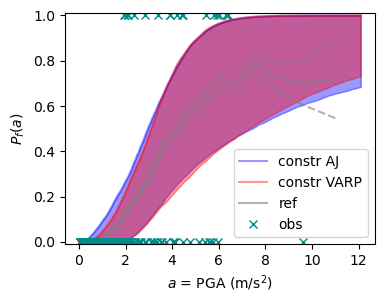

In [15]:
#3. output an example of estimate
from bayes_frag import config
from bayes_frag.data import Data
from bayes_frag.reference_curves import Reference_saved_MLE

data = Data('PGA', csv_path='Res_ASG_SA_PGA_RL_RNL_80000.csv', quantile_C=0.9, name_inte='rot_nlin', shuffle=True)
ref = Reference_saved_MLE(data, os.path.join(config.data_path, 'ref_MLE_ASG_80000_{}'.format('PGA')))
num_clust = 25
ref._compute_empirical_curves(num_clust) 
ref._compute_MC_data_tab()

numb_file= 30
N = 50

file_VARP = os.path.join(base_dir, r'SUR_alpha_impact/run_AJ/model_noSUR_VARP_adpt_{}'.format(numb_file))
file_J = os.path.join(base_dir, r'SUR_alpha_impact/run_AJ/model_noSUR_J_adpt_{}'.format(numb_file))


def compute_frags_cred(theta) :
    curves = 1/2 + 1/2*spc.erf( (np.log(data.a_tab)[None] - np.log(theta[:,None,0]))/theta[:,None,1] )
    q1 = np.quantile(curves, 1-0.05/2, axis=0)
    q2 = np.quantile(curves, 0.05/2, axis=0)
    return q1,q2

model_J = pickle.load(open(file_J, 'rb'))
model_VARP = pickle.load(open(file_VARP, 'rb'))

fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot()
q1,q2 = compute_frags_cred(model_J['logs']['post'][50])
ax.fill_between(data.a_tab, q1, q2, color='blue', alpha=0.4)
ax.plot(data.a_tab, q1, color='blue', alpha=0.4, label='constr AJ')

q1,q2 = compute_frags_cred(model_VARP['logs']['post'][50])
ax.fill_between(data.a_tab, q1, q2, color='red', alpha=0.4)
ax.plot(data.a_tab, q1, color='red', alpha=0.4, label='constr VARP')

ax.plot(ref.a_tab_MC, ref.curve_MC, color='grey', alpha=0.6, label='ref')
ax.plot(ref.a_tab_MC, ref.curve_MC-ref.curve_MC_var, '--', color='grey', alpha=0.6)
ax.plot(ref.a_tab_MC, ref.curve_MC+ref.curve_MC_var, '--', color='grey', alpha=0.6)

ax.plot(model_J['A'], model_J['S'], 'x', color='darkcyan', label='obs')

ax.legend()
ax.set_ylim(-0.01, 1.01)
ax.set_xlabel(r'$a$ = PGA (m/s$^2$)')
ax.set_ylabel(r'$P_f(a)$')



In [11]:
model_J


{'logs': {'post': {10: array([[4.42745094e+00, 1.05084351e-01],
          [4.41584832e+00, 1.23174283e-01],
          [4.41584832e+00, 1.23174283e-01],
          ...,
          [3.11281861e+00, 3.77103548e-03],
          [3.11281861e+00, 3.77103548e-03],
          [3.11281861e+00, 3.77103548e-03]]),
   20: array([[3.79356738, 0.35057274],
          [3.87189869, 0.15563381],
          [3.87189869, 0.15563381],
          ...,
          [4.55943765, 0.38818723],
          [4.19057718, 0.18722692],
          [4.24591699, 0.21524259]]),
   30: array([[3.06315149, 0.52196479],
          [2.8829217 , 0.50011165],
          [3.13607998, 0.40731462],
          ...,
          [3.37465336, 1.12921408],
          [3.46884147, 1.03754379],
          [3.24657449, 0.33484165]]),
   40: array([[4.12714055, 0.79119548],
          [4.12714055, 0.79119548],
          [4.08659229, 1.1317854 ],
          ...,
          [4.2777496 , 0.84634167],
          [4.2777496 , 0.84634167],
          [4.2777496 , 0.8